# Application 1 Heterokedasticity

This script describes the application of multiple linear regression technique using the [statsmodel](https://www.statsmodels.org/) library and the interpretation of its outputs. Initially, a regression will be performed using only one predictor variable, then new dummy variables will be added, and the results will be compared.


## Dataset Description

"It is a database of over 40,000 schools in Brazil, including the state, municipality, school code, school name, network (municipal, state or federal), 'saeb' (which is a set of external evaluations aimed at diagnosing learning), and 'rendimento' which is the flow between approval and disapproval and will be the dependent variable of the model.

## Implementation

- Check the dataset.


- Descriptive Statistics.


- Adjust the model.


- Checking the Heterokedasticity.


- Adjust the model (with more variables).


- Comparing the results.


***

## Checking the Dataset

In [167]:
# Libraries needed
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sfrancia import shapiroFrancia
from scipy.stats import boxcox

sns.set()
warnings.filterwarnings("ignore")

In [168]:
# Checking the Data
df_rend = pd.read_csv('Data/saeb_rend.csv')
df_rend.head(5)

,uf,municipio,codigo,escola,rede,saeb,rendimento
0,RO,Alta Floresta D'Oeste,11024666,EMEIEF BOA ESPERANCA,Municipal,5.331833,0.766092
1,RO,Alta Floresta D'Oeste,11024682,EEEF EURIDICE LOPES PEDROSO,Estadual,NaN,0.910890
2,RO,Alta Floresta D'Oeste,11024828,EMEIEF IZIDORO STEDILE,Municipal,5.432333,0.884658
3,RO,Alta Floresta D'Oeste,11024917,EMEIEF JOSE BASILIO DA GAMA,Municipal,NaN,NaN
4,RO,Alta Floresta D'Oeste,11024968,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,5.568833,0.957629


In [169]:
# Checking NaN values
df_rend.isna().sum()

uf                0
municipio         0
codigo            0
escola            0
rede              0
saeb          18069
rendimento     6283
dtype: int64

In [170]:
# Checking parameters types
df_rend.dtypes

uf             object
municipio      object
codigo          int64
escola         object
rede           object
saeb          float64
rendimento    float64
dtype: object

'codigo' shouldn't be an intenger, but this variable will not be used anyway.

In [106]:
# Dropping NaN values
df_rend = df_rend.dropna()

## Descriptive Statistics

In [107]:
# Descriptive statistics
df_rend.describe().T.round(2).drop('count',1)[1:]

,mean,std,min,25%,50%,75%,max
saeb,5.05,0.75,2.05,4.55,5.07,5.55,8.59
rendimento,0.87,0.10,0.26,0.82,0.90,0.95,1.00


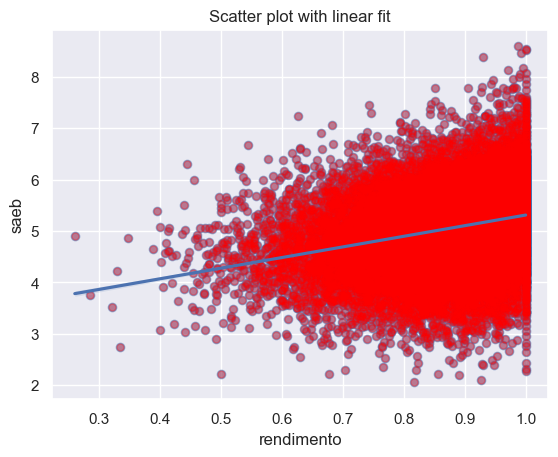

In [108]:
# Plotting the Scatter Graph of 'rendimento' over 'saeb'
plt.plot(df_rend['rendimento'], df_rend['saeb'], 'o', color='red', markersize=5, alpha=0.3)
sns.regplot(x="rendimento", y="saeb", data=df_rend, scatter_kws={'alpha':0.5} )
plt.title('Scatter plot with linear fit')
plt.xlabel('rendimento')
plt.ylabel('saeb')
plt.show()

It is clear from the graph that the higher the value of y ('rendimento'), the larger the errors.

This distribution indicates that there is a correlation between x and the error terms (higher x, higher error terms). As this correlation is different from 0, we have a phenomenon called **heteroscedasticity** - non-constant variance of the error terms with respect to x (or vector of x variables).

This correlation indicates that somehow **the error term is correlated with y**, which suggests that there is some x variable that has been omitted and would be a good predictor of the model.

## Adjusting the model

The first model will be created considering just 'saeb' as a predictor variable, and 'rendimento' as the dependent varriable.

In [109]:
# Splitting predictor and dependent variables
X = df_rend['rendimento'].values
y = df_rend['saeb'].values

In [110]:
# Adding the constant, for considering the intercept
X = sm.add_constant(X)

In [111]:
# Fit the linear regression model (OLS method)
model1 = sm.OLS(y, X).fit()

In [112]:
# Summary statistics
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2126.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:22:52   Log-Likelihood:                -27984.
No. Observations:               25530   AIC:                         5.597e+04
Df Residuals:                   25528   BIC:                         5.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2425      0.039     82.277      0.0

## Checking Heterokedasticity

The Breusch-Pagan test is used to identify the heteroskedasticity phenomenon.

In the test, a new linear regression model must be created, where 'up' is the dependent variable and the predicted values from the model which one wants to evaluate the heteroskedasticity will be the independent variable. Where 'up' values are calculated as:

$ up_i = \large\frac {res_i^{2}}{\large\frac{\sum res^{2}}{N}} $

Through the (auxiliary) linear regression model of 'up' as a function of the 'fitted values' of the original model, the SQReg is obtained, a value that, divided by two, corresponds to the chi-squared statistic, and if the p-value corresponding to this statistic is less than 0.05, heteroscedasticity can be observed according to the Breusch-Pagan.

In [126]:
# Creating a Breusch-Pagan Test Function
def breusch_pagan_test(model):

    # Creating a Auxiliar DataFrame
    df = pd.DataFrame({'yhat':model.fittedvalues,
                       'resid':model.resid})
   
    # Getting up values
    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))
    
    # Creating a auxiliar model
    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()
   
    # Getting the model's anova table
    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)
    anova_table['sum_sq'] = anova_table['sum_sq']/2
    
    # Getting chisq and p-values
    chisq = anova_table['sum_sq'].iloc[0]
    p_value = stats.chi2.pdf(chisq, 1)*2
    
    # Printing Values
    print(f"chisq: {chisq}")
    print(f"p-value: {p_value}")
    
    return 

In [127]:
# Testing Heterokedasticity
breusch_pagan_test(model1)

chisq: 16.720700325953274
p-value: 4.565190314938955e-05


As can be seen, the Breusch-Pagan test confirms the presence of heteroscedasticity, a phenomenon that could already be observed through the scatter plot. 


## Adjusting the model

The first model will be created considering just 'saeb' as a predictor variable, and 'rendimento' as the dependent varriable.

In [134]:
# Adding the dummie variables
df_rend1 = df_rend[['rendimento', 'saeb']].merge(pd.get_dummies(df_rend['uf'], drop_first=True, prefix='UF'), how='outer', left_index=True, right_index=True)

In [135]:
# Splitting predictor and dependent variables
X_1 = df_rend1.drop('saeb', 1).values
y_1 = df_rend1['saeb'].values

In [136]:
# Adding the constant
X_1 = sm.add_constant(X_1)

In [137]:
# Fit themodel 
model2 = sm.OLS(y_1, X_1).fit()

In [138]:
# Summary statistics
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     497.5
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:27:54   Log-Likelihood:                -23604.
No. Observations:               25530   AIC:                         4.726e+04
Df Residuals:                   25502   BIC:                         4.749e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7566      0.071     53.118      0.0

In [139]:
# Testing Heterokedasticity
breusch_pagan_test(model2)

chisq: 1.0756241898379826
p-value: 0.4493046942889977



## Conclusions

The goal of this notebook was to show the impact of the heterokedascity on a model. The first model, just considering 'rendimento' as a predictor variable was impacted by the heterokedascity, that can be treated only by the addition of more predictor variables (statistically significant). Once the state dummies variable was considered, the model had no more heterokedasticity. It's relevant to observer that the R² increased considerably with the dummy variables addition.
